# Pulse Wave Analysis
In this tutorial we will learn how to extract features from PPG pulse waves.

The **objectives** are:
- To use a function to detect several fiducial points on PPG pulse waves
- To calculate pulse wave features from the fiducial points

<div class="alert alert-block alert-warning"> <b>Context:</b> One approach to estimating BP from PPG signals consists of extracting features from PPG pulse waves, and then using these as inputs to BP estimation model. This tutorial covers the first of these steps: extracting features from PPG pulse waves.</div>

<div class="alert alert-block alert-info"> <b>Resource:</b> You can read more about pulse wave analysis in Sections 3.2.2 and 3.2.3 of <a href="https://peterhcharlton.github.io/publication/ppg_sig_proc_chapter/">this book</a>.</div>

---
## Setup

- Specify the required Python packages

In [1]:
import sys
import numpy as np
import scipy.signal as sp

from matplotlib import pyplot as plt

import wfdb

- Specify the settings for the MIMIC-III database

In [2]:
wfdb.set_db_index_url('https://physionet.org/files') # use the version of the WFDB toolbox which corresponds to MIMIC IV.
database_name = 'mimic3wdb/1.0' # The name of the MIMIC III Waveform Database on Physionet (see URL: https://physionet.org/content/mimic3wdb/1.0/)

- Provide a list of segments which meet the requirements for the study

In [3]:
segment_names = ['3000063_0013']
segment_dirs = ['mimic3wdb/1.0/30/3000063/']

- Specify a segment from which to extract data

In [4]:
rel_segment_no = 0
rel_segment_name = segment_names[rel_segment_no]
rel_segment_dir = segment_dirs[rel_segment_no]
print("Specified segment '{}' in directory '{}'".format(rel_segment_name, rel_segment_dir))

Specified segment '3000063_0013' in directory 'mimic3wdb/1.0/30/3000063/'


---
## Extract data
Extract data from this segment

- Specify the duration to be extracted

In [7]:
start_time = 60 # time since the start of the segment at which to begin extracting data
no_seconds_to_load = 10

- Find out the sampling frequency of the waveform data

In [8]:
segment_metadata = wfdb.rdheader(record_name=rel_segment_name, pn_dir=rel_segment_dir)
fs = segment_metadata.fs
print("Sampling frequency is {} Hz".format(fs))

Sampling frequency is 125 Hz


- Extract this duration of signals from the longer segment

In [9]:
segment_data = wfdb.rdrecord(record_name = rel_segment_name, sampfrom = fs*start_time, sampto = fs*(start_time + no_seconds_to_load), pn_dir = rel_segment_dir) 
print("{} seconds of data loaded from segment '{}'".format(no_seconds_to_load, rel_segment_name))

10 seconds of data loaded from segment '3000063_0013'


- Extract the PPG signal

In [11]:
abp_col = []
for sig_no in range(0,len(segment_data.sig_name)):
    if "PLETH" in segment_data.sig_name[sig_no]:
        ppg_col = sig_no
ppg = segment_data.p_signal[:,ppg_col]
fs = segment_data.fs
print("Extracted the PPG signal from column {} of the matrix of waveform data.".format(ppg_col))
print("Sampled at {} Hz.".format(segment_data.fs))

Extracted the PPG signal from column 2 of the matrix of waveform data.
Sampled at 125 Hz.


---
## Filter the PPG signal

In [12]:
import scipy.signal as sp
sos_filter = sp.butter(10, [0.7, 10], btype = 'bp', analog = False, output = 'sos', fs = segment_data.fs)
ppg_filt = sp.sosfiltfilt(sos_filter, ppg)

---
## Beat Detection

In [15]:
%run beat_detection_functions
ibis = pulse_detect(ppg_filt,fs,5,'d2max')
print("Detected {} beats in the PPG signal using the {} algorithm".format(len(ibis), "D2max"))

Detected 17 beats in the PPG signal using the D2max algorithm


---
---
**... Pete to continue from here ...**

---
---

## Identify fiducial points on pulse waves

- Define the required functions

In [194]:
def fiducial_points(x,pks,fs,vis):
    """
    Description: Pulse detection and correction from pulsatile signals
    Inputs:  x, array with pulsatile signal [user defined units]
             pks, array with the position of the peaks [number of samples]
             fs, sampling rate of signal [Hz]
             vis, visualisation option [True, False]
    Outputs: fidp, dictionary with the positions of several fiducial points for the cardiac cycles [number of samples]
    
    Fiducial points:  1: Systolic peak (pks)
                      2: Onset, as the minimum before the systolic peak (ons)
                      3: Onset, using the tangent intersection method (ti) 
                      4: Diastolic peak (dpk)
                      5: Maximum slope (m1d)
                      6: a point from second derivative PPG (a2d)
                      7: b point from second derivative PPG (b2d)
                      8: c point from second derivative PPG (c2d)
                      9: d point from second derivative PPG (d2d)
                      10: e point from second derivative PPG (e2d)
                      11: p1 from the third derivative PPG (p1)    
                      12: p2 from the third derivative PPG (p2)
    
    Libraries: NumPy (as np), SciPy (Signal, as sp), Matplotlib (PyPlot, as plt)
    
    Version: 1.0 - June 2022
    
    Developed by: Elisa Mejía-Mejía
                   City, University of London
    
    Edited by: Peter Charlton (see "Added by PC")
    
    """    
    # First, second and third derivatives
    d1x = sp.savgol_filter(x, 9, 5, deriv = 1) 
    d2x = sp.savgol_filter(x, 9, 5, deriv = 2) 
    d3x = sp.savgol_filter(x, 9, 5, deriv = 3) 
    
    #plt.figure()
    #plt.plot(x/np.max(x))
    #plt.plot(d1x/np.max(d1x))
    #plt.plot(d2x/np.max(d2x))
    #plt.plot(d3x/np.max(d3x))
    
    # Search in time series: Onsets between consecutive peaks
    ons = np.empty(0)
    for i in range(len(pks) - 1):
        start = pks[i]
        stop = pks[i + 1]
        ibi = x[start:stop]
        #plt.figure()
        #plt.plot(ibi, color = 'black')
        aux_ons, = np.where(ibi == np.min(ibi))
        ind_ons = aux_ons.astype(int)
        ons = np.append(ons, ind_ons + start)   
        #plt.plot(ind_ons, ibi[ind_ons], marker = 'o', color = 'red') 
    ons = ons.astype(int)
    #print('Onsets: ' + str(ons))
    #plt.figure()
    #plt.plot(x, color = 'black')
    #plt.scatter(pks, x[pks], marker = 'o', color = 'red') 
    #plt.scatter(ons, x[ons], marker = 'o', color = 'blue') 
    
    # Search in time series: Diastolic peak and dicrotic notch between consecutive onsets
    dia = np.empty(0)
    dic = np.empty(0)
    for i in range(len(ons) - 1):
        start = ons[i]
        stop = ons[i + 1]
        ind_pks, = np.intersect1d(np.where(pks < stop), np.where(pks > start))
        ind_pks = pks[ind_pks]
        ibi_portion = x[ind_pks:stop]
        ibi_2d_portion = d2x[ind_pks:stop]
        #plt.figure()
        #plt.plot(ibi_portion/np.max(ibi_portion))
        #plt.plot(ibi_2d_portion/np.max(ibi_2d_portion))
        aux_dic, _ = sp.find_peaks(ibi_2d_portion)
        aux_dic = aux_dic.astype(int)
        aux_dia, _ = sp.find_peaks(-ibi_2d_portion)
        aux_dia = aux_dia.astype(int)   
        if len(aux_dic) != 0:
            ind_max, = np.where(ibi_2d_portion[aux_dic] == np.max(ibi_2d_portion[aux_dic]))
            aux_dic_max = aux_dic[ind_max]
            if len(aux_dia) != 0:
                nearest = aux_dia - aux_dic_max
                aux_dic = aux_dic_max
                dic = np.append(dic, (aux_dic + ind_pks).astype(int))
                #plt.scatter(aux_dic, ibi_portion[aux_dic]/np.max(ibi_portion), marker = 'o')
                ind_dia, = np.where(nearest > 0)
                aux_dia = aux_dia[ind_dia]
                nearest = nearest[ind_dia]
                if len(nearest) != 0:
                    ind_nearest, = np.where(nearest == np.min(nearest))
                    aux_dia = aux_dia[ind_nearest]
                    dia = np.append(dia, (aux_dia + ind_pks).astype(int))
                    #plt.scatter(aux_dia, ibi_portion[aux_dia]/np.max(ibi_portion), marker = 'o')
                    #break
            else:
                dic = np.append(dic, (aux_dic_max + ind_pks).astype(int))
                #plt.scatter(aux_dia, ibi_portion[aux_dia]/np.max(ibi_portion), marker = 'o')     
    dia = dia.astype(int)
    dic = dic.astype(int)
    #plt.scatter(dia, x[dia], marker = 'o', color = 'orange')
    #plt.scatter(dic, x[dic], marker = 'o', color = 'green')
    
    # Search in D1: Maximum slope point
    m1d = np.empty(0)
    for i in range(len(ons) - 1):
        start = ons[i]
        stop = ons[i + 1]
        ind_pks, = np.intersect1d(np.where(pks < stop), np.where(pks > start))
        ind_pks = pks[ind_pks]
        ibi_portion = x[start:ind_pks]
        ibi_1d_portion = d1x[start:ind_pks]
        #plt.figure()
        #plt.plot(ibi_portion/np.max(ibi_portion))
        #plt.plot(ibi_1d_portion/np.max(ibi_1d_portion))
        aux_m1d, _ = sp.find_peaks(ibi_1d_portion)
        aux_m1d = aux_m1d.astype(int)  
        if len(aux_m1d) != 0:
            ind_max, = np.where(ibi_1d_portion[aux_m1d] == np.max(ibi_1d_portion[aux_m1d]))
            aux_m1d_max = aux_m1d[ind_max]
            if len(aux_m1d_max) > 1:
                aux_m1d_max = aux_m1d_max[0]
            m1d = np.append(m1d, (aux_m1d_max + start).astype(int))
            #plt.scatter(aux_m1d, ibi_portion[aux_dic]/np.max(ibi_portion), marker = 'o')
            #break    
    m1d = m1d.astype(int)
    #plt.scatter(m1d, x[m1d], marker = 'o', color = 'purple')
    
    # Search in time series: Tangent intersection points
    tip = np.empty(0)
    for i in range(len(ons) - 1):
        start = ons[i]
        stop = ons[i + 1]
        ibi_portion = x[start:stop]
        ibi_1d_portion = d1x[start:stop]
        ind_m1d, = np.intersect1d(np.where(m1d < stop), np.where(m1d > start))
        ind_m1d = m1d[ind_m1d] - start
        #plt.figure()
        #plt.plot(ibi_portion/np.max(ibi_portion))
        #plt.plot(ibi_1d_portion/np.max(ibi_1d_portion))
        #plt.scatter(ind_m1d, ibi_portion[ind_m1d]/np.max(ibi_portion), marker = 'o')
        #plt.scatter(ind_m1d, ibi_1d_portion[ind_m1d]/np.max(ibi_1d_portion), marker = 'o')
        aux_tip = np.round(((ibi_portion[0] - ibi_portion[ind_m1d])/ibi_1d_portion[ind_m1d]) + ind_m1d)
        aux_tip = aux_tip.astype(int)
        tip = np.append(tip, (aux_tip + start).astype(int))        
        #plt.scatter(aux_tip, ibi_portion[aux_tip]/np.max(ibi_portion), marker = 'o')
        #break
    tip = tip.astype(int)
    #plt.scatter(tip, x[tip], marker = 'o', color = 'aqua')
    
    # Search in D2: A, B, C, D and E points
    a2d = np.empty(0)
    b2d = np.empty(0)
    c2d = np.empty(0)
    d2d = np.empty(0)
    e2d = np.empty(0)
    for i in range(len(ons) - 1):
        start = ons[i]
        stop = ons[i + 1]
        ibi_portion = x[start:stop]
        ibi_1d_portion = d1x[start:stop]
        ibi_2d_portion = d2x[start:stop]
        ind_m1d = np.intersect1d(np.where(m1d > start),np.where(m1d < stop))
        ind_m1d = m1d[ind_m1d]
        #plt.figure()
        #plt.plot(ibi_portion/np.max(ibi_portion))
        #plt.plot(ibi_1d_portion/np.max(ibi_1d_portion))
        #plt.plot(ibi_2d_portion/np.max(ibi_2d_portion))
        aux_m2d_pks, _ = sp.find_peaks(ibi_2d_portion)
        aux_m2d_ons, _ = sp.find_peaks(-ibi_2d_portion)
        # a point:
        ind_a, = np.where(ibi_2d_portion[aux_m2d_pks] == np.max(ibi_2d_portion[aux_m2d_pks]))
        ind_a = aux_m2d_pks[ind_a]
        if (ind_a < ind_m1d):
            a2d = np.append(a2d, ind_a + start)
            #plt.scatter(ind_a, ibi_2d_portion[ind_a]/np.max(ibi_2d_portion), marker = 'o')
            # b point:
            ind_b = np.where(ibi_2d_portion[aux_m2d_ons] == np.min(ibi_2d_portion[aux_m2d_ons]))
            ind_b = aux_m2d_ons[ind_b]
            if (ind_b > ind_a) and (ind_b < len(ibi_2d_portion)):
                b2d = np.append(b2d, ind_b + start)
                #plt.scatter(ind_b, ibi_2d_portion[ind_b]/np.max(ibi_2d_portion), marker = 'o')
        # e point:
        ind_e, = np.where(aux_m2d_pks > ind_m1d - start)
        aux_m2d_pks = aux_m2d_pks[ind_e]
        ind_e, = np.where(aux_m2d_pks < 0.6*len(ibi_2d_portion))
        ind_e = aux_m2d_pks[ind_e]
        if len(ind_e) >= 1:
            if len(ind_e) >= 2:
                ind_e = ind_e[1]
            e2d = np.append(e2d, ind_e + start)
            #plt.scatter(ind_e, ibi_2d_portion[ind_e]/np.max(ibi_2d_portion), marker = 'o')
            # c point:
            ind_c, = np.where(aux_m2d_pks < ind_e)
            if len(ind_c) != 0:
                ind_c_aux = aux_m2d_pks[ind_c]
                ind_c, = np.where(ibi_2d_portion[ind_c_aux] == np.max(ibi_2d_portion[ind_c_aux]))
                ind_c = ind_c_aux[ind_c]
                if len(ind_c) != 0:
                    c2d = np.append(c2d, ind_c + start)
                    #plt.scatter(ind_c, ibi_2d_portion[ind_c]/np.max(ibi_2d_portion), marker = 'o')
            else:
                aux_m1d_ons, _ = sp.find_peaks(-ibi_1d_portion)
                ind_c, = np.where(aux_m1d_ons < ind_e)
                ind_c_aux = aux_m1d_ons[ind_c]
                if len(ind_c) != 0:
                    ind_c, = np.where(ind_c_aux > ind_b)
                    ind_c = ind_c_aux[ind_c]
                    if len(ind_c) > 1:
                        ind_c = ind_c[0]
                    c2d = np.append(c2d, ind_c + start)
                    #plt.scatter(ind_c, ibi_2d_portion[ind_c]/np.max(ibi_2d_portion), marker = 'o')
            # d point:
            if len(ind_c) != 0:
                ind_d = np.intersect1d(np.where(aux_m2d_ons < ind_e), np.where(aux_m2d_ons > ind_c))
                if len(ind_d) != 0:
                    ind_d_aux = aux_m2d_ons[ind_d]
                    ind_d, = np.where(ibi_2d_portion[ind_d_aux] == np.min(ibi_2d_portion[ind_d_aux]))
                    ind_d = ind_d_aux[ind_d]
                    if len(ind_d) != 0:
                        d2d = np.append(d2d, ind_d + start)
                        #plt.scatter(ind_d, ibi_2d_portion[ind_d]/np.max(ibi_2d_portion), marker = 'o')                
                else:
                    ind_d = ind_c
                    d2d = np.append(d2d, ind_d + start)
                    #plt.scatter(ind_d, ibi_2d_portion[ind_d]/np.max(ibi_2d_portion), marker = 'o')
    a2d = a2d.astype(int)
    b2d = b2d.astype(int)
    c2d = c2d.astype(int)
    d2d = d2d.astype(int)
    e2d = e2d.astype(int)
    #plt.figure()
    #plt.plot(d2x, color = 'black')
    #plt.scatter(a2d, d2x[a2d], marker = 'o', color = 'red') 
    #plt.scatter(b2d, d2x[b2d], marker = 'o', color = 'blue')
    #plt.scatter(c2d, d2x[c2d], marker = 'o', color = 'green')
    #plt.scatter(d2d, d2x[d2d], marker = 'o', color = 'orange')
    #plt.scatter(e2d, d2x[e2d], marker = 'o', color = 'purple')
    
    # Search in D3: P1 and P2 points
    p1p = np.empty(0)
    p2p = np.empty(0)
    for i in range(len(ons) - 1):
        start = ons[i]
        stop = ons[i + 1]
        ibi_portion = x[start:stop]
        ibi_1d_portion = d1x[start:stop]
        ibi_2d_portion = d2x[start:stop]
        ibi_3d_portion = d3x[start:stop]
        ind_b = np.intersect1d(np.where(b2d > start),np.where(b2d < stop))
        ind_b = b2d[ind_b]
        ind_c = np.intersect1d(np.where(c2d > start),np.where(c2d < stop))
        ind_c = c2d[ind_c]
        ind_d = np.intersect1d(np.where(d2d > start),np.where(d2d < stop))
        ind_d = d2d[ind_d]
        ind_dic = np.intersect1d(np.where(dic > start),np.where(dic < stop))
        ind_dic = dic[ind_dic]
        #plt.figure()
        #plt.plot(ibi_portion/np.max(ibi_portion))
        #plt.plot(ibi_1d_portion/np.max(ibi_1d_portion))
        #plt.plot(ibi_2d_portion/np.max(ibi_2d_portion))
        #plt.plot(ibi_3d_portion/np.max(ibi_3d_portion))
        #plt.scatter(ind_b - start, ibi_3d_portion[ind_b - start]/np.max(ibi_3d_portion), marker = 'o')
        #plt.scatter(ind_c - start, ibi_3d_portion[ind_c - start]/np.max(ibi_3d_portion), marker = 'o')
        #plt.scatter(ind_d - start, ibi_3d_portion[ind_d - start]/np.max(ibi_3d_portion), marker = 'o')
        #plt.scatter(ind_dic - start, ibi_3d_portion[ind_dic - start]/np.max(ibi_3d_portion), marker = 'o')
        aux_p3d_pks, _ = sp.find_peaks(ibi_3d_portion)
        aux_p3d_ons, _ = sp.find_peaks(-ibi_3d_portion)
        # P1:
        if (len(aux_p3d_pks) != 0 and len(ind_b) != 0):
            ind_p1, = np.where(aux_p3d_pks > ind_b - start)
            if len(ind_p1) != 0:
                ind_p1 = aux_p3d_pks[ind_p1[0]]
                p1p = np.append(p1p, ind_p1 + start)
                #plt.scatter(ind_p1, ibi_3d_portion[ind_p1]/np.max(ibi_3d_portion), marker = 'o')
        # P2:
        if (len(aux_p3d_ons) != 0 and len(ind_c) != 0 and len(ind_d) != 0):
            if ind_c == ind_d:
                ind_p2, = np.where(aux_p3d_ons > ind_d - start)
                ind_p2 = aux_p3d_ons[ind_p2[0]]
            else:
                ind_p2, = np.where(aux_p3d_ons < ind_d - start)
                ind_p2 = aux_p3d_ons[ind_p2[-1]]
            if len(ind_dic) != 0:
                aux_x_pks, _ = sp.find_peaks(ibi_portion)
                if ind_p2 > ind_dic - start:
                    ind_between = np.intersect1d(np.where(aux_x_pks < ind_p2), np.where(aux_x_pks > ind_dic - start))
                else:
                    ind_between = np.intersect1d(np.where(aux_x_pks > ind_p2), np.where(aux_x_pks < ind_dic - start))
                if len(ind_between) != 0:
                    ind_p2 = aux_x_pks[ind_between[0]]
            p2p = np.append(p2p, ind_p2 + start)
            #plt.scatter(ind_p2, ibi_3d_portion[ind_p2]/np.max(ibi_3d_portion), marker = 'o')
    p1p = p1p.astype(int)
    p2p = p2p.astype(int)
    #plt.figure()
    #plt.plot(d3x, color = 'black')
    #plt.scatter(p1p, d3x[p1p], marker = 'o', color = 'green') 
    #plt.scatter(p2p, d3x[p2p], marker = 'o', color = 'orange')
    
    # Added by PC: Magnitudes of second derivative points
    bmag2d = np.zeros(len(b2d))
    cmag2d = np.zeros(len(b2d))
    dmag2d = np.zeros(len(b2d))
    emag2d = np.zeros(len(b2d))
    for beat_no in range(0,len(b2d)):
        bmag2d[beat_no] = d2x[b2d[beat_no]]/d2x[a2d[beat_no]]
        cmag2d[beat_no] = d2x[c2d[beat_no]]/d2x[a2d[beat_no]]
        dmag2d[beat_no] = d2x[d2d[beat_no]]/d2x[a2d[beat_no]]        
        emag2d[beat_no] = d2x[e2d[beat_no]]/d2x[a2d[beat_no]]    
        
     # Added by PC: Refine the list of fiducial points to only include those corresponding to beats for which a full set of points is available
    off = ons[1:]
    ons = ons[:-1]
    if pks[0] < ons[0]:
        pks = pks[1:]
    if pks[-1] > off[-1]:
        pks = pks[:-1]
    
    # Visualise results
    if vis == True:
        fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, 1, sharex = True, sharey = False, figsize=(10,10))
        fig.suptitle('Fiducial points') 

        ax1.plot(x, color = 'black')
        ax1.scatter(pks, x[pks.astype(int)], color = 'orange', label = 'pks')
        ax1.scatter(ons, x[ons.astype(int)], color = 'green', label = 'ons')
        ax1.scatter(off, x[off.astype(int)], marker = '*', color = 'green', label = 'off')
        ax1.scatter(dia, x[dia.astype(int)], color = 'yellow', label = 'dia')
        ax1.scatter(dic, x[dic.astype(int)], color = 'blue', label = 'dic')
        ax1.scatter(tip, x[tip.astype(int)], color = 'purple', label = 'dic')
        ax1.legend()
        ax1.set_ylabel('x')

        ax2.plot(d1x, color = 'black')
        ax2.scatter(m1d, d1x[m1d.astype(int)], color = 'orange', label = 'm1d')
        ax2.legend()
        ax2.set_ylabel('d1x')

        ax3.plot(d2x, color = 'black')
        ax3.scatter(a2d, d2x[a2d.astype(int)], color = 'orange', label = 'a')
        ax3.scatter(b2d, d2x[b2d.astype(int)], color = 'green', label = 'b')
        ax3.scatter(c2d, d2x[c2d.astype(int)], color = 'yellow', label = 'c')
        ax3.scatter(d2d, d2x[d2d.astype(int)], color = 'blue', label = 'd')
        ax3.scatter(e2d, d2x[e2d.astype(int)], color = 'purple', label = 'e')
        ax3.legend()
        ax3.set_ylabel('d2x')

        ax4.plot(d3x, color = 'black')
        ax4.scatter(p1p, d3x[p1p.astype(int)], color = 'orange', label = 'p1')
        ax4.scatter(p2p, d3x[p2p.astype(int)], color = 'green', label = 'p2')
        ax4.legend()
        ax4.set_ylabel('d3x')

        plt.subplots_adjust(left = 0.1,
                            bottom = 0.1, 
                            right = 0.9, 
                            top = 0.9, 
                            wspace = 0.4, 
                            hspace = 0.4)
        
    # Creation of dictionary
    fidp = {'pks': pks.astype(int),
            'ons': ons.astype(int),
            'off': off.astype(int),  # Added by PC
            'tip': tip.astype(int),
            'dia': dia.astype(int),
            'dic': dic.astype(int),
            'm1d': m1d.astype(int),
            'a2d': a2d.astype(int),
            'b2d': b2d.astype(int),
            'c2d': c2d.astype(int),
            'd2d': d2d.astype(int),
            'e2d': e2d.astype(int),
            'bmag2d': bmag2d,
            'cmag2d': cmag2d,
            'dmag2d': dmag2d,
            'emag2d': emag2d,
            'p1p': p1p.astype(int),
            'p2p': p2p.astype(int)
            }
    
    return fidp

- Identify and visualise fiducial points

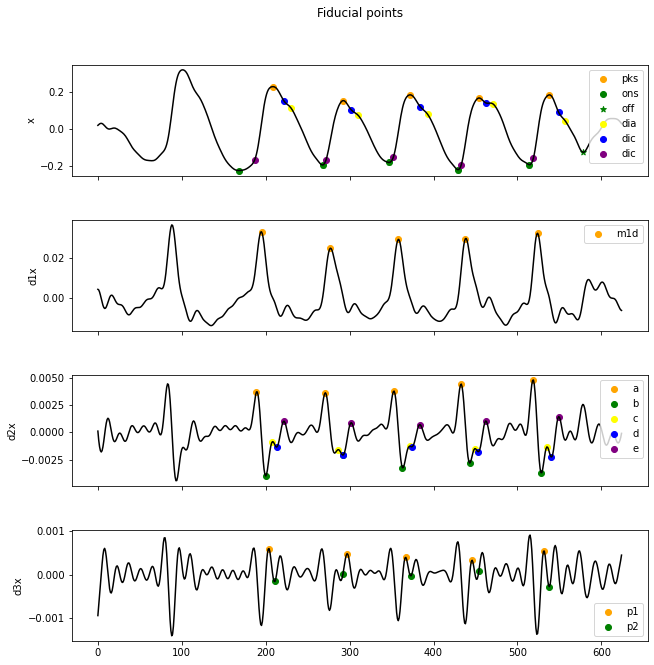

In [195]:
fidp = fiducial_points(ppg_filt,ibis,fs,vis = True)

## Calculate pulse wave features
We will now calculate pulse wave features from the amplitudes and timings of the fiducial points on each pulse wave

- Note how the data are stored in the variable `fidp`:

In [196]:
from pprint import pprint
pprint(fidp)

{'a2d': array([189, 271, 353, 433, 519]),
 'b2d': array([200, 292, 363, 443, 528]),
 'bmag2d': array([-1.07086351, -0.5696967 , -0.85134426, -0.63233677, -0.76560773]),
 'c2d': array([208, 286, 372, 449, 535]),
 'cmag2d': array([-0.22573998, -0.43480793, -0.33363513, -0.33525452, -0.2759608 ]),
 'd2d': array([213, 292, 374, 453, 540]),
 'dia': array([230, 310, 393, 471, 557]),
 'dic': array([222, 302, 384, 462, 549]),
 'dmag2d': array([-0.35968829, -0.5696967 , -0.34558544, -0.39701305, -0.46525541]),
 'e2d': array([222, 302, 384, 462, 549]),
 'emag2d': array([0.27544615, 0.24510258, 0.18867102, 0.23560275, 0.30114416]),
 'm1d': array([195, 277, 358, 438, 524]),
 'off': array([268, 347, 429, 514, 578]),
 'ons': array([168, 268, 347, 429, 514]),
 'p1p': array([204, 297, 367, 446, 532]),
 'p2p': array([211, 292, 373, 454, 538]),
 'pks': array([209, 292, 372, 454, 538]),
 'tip': array([187, 272, 352, 433, 519])}


- `fidp` is a dictionary consisting of several arrays (one per fiducial point), with each array containing the indices of that fiducial point for all of the pulse waves. For instance, we can inspect the indices of the dicrotic notches (`dic`) using:

In [197]:
print("Indices of dicrotic notches:")
print(fidp["dic"])

Indices of dicrotic notches:
[222 302 384 462 549]


- We'll start off by calculating $\Delta$T, the time delay between systolic and diastolic peaks (`pks` and `dia`):

In [198]:
delta_t = np.zeros(len(fidp["dia"]))
for beat_no in range(len(fidp["dia"])):
    delta_t[beat_no] = (fidp["dia"][beat_no]-fidp["pks"][beat_no])/fs
print("Values of Delta T:")
print(delta_t)

Values of Delta T:
[0.168 0.144 0.168 0.136 0.152]


- Now we'll calculate a second pulse wave feature, the aging index:

In [199]:
agi = np.zeros(len(fidp["dia"]))
for beat_no in range(len(fidp["dia"])):
    agi[beat_no] = (fidp["bmag2d"][beat_no]-fidp["cmag2d"][beat_no]-fidp["dmag2d"][beat_no]-fidp["emag2d"][beat_no])/fs
print("Values of Aging Index:")
print(agi)

Values of Aging Index:
[-0.00608705  0.00151764 -0.00288636 -0.00108538 -0.00260429]
